In [1]:
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
import pytorch_lightning as pl
from torch.nn.parameter import Parameter
from torchmetrics import PeakSignalNoiseRatio
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import datetime, random
import csv
import os
import argparse
from models import CondEnergyModel, EnergyModel, UNet, MyResnet
from ResNet import IGEBM, Res6_Quadratic, Res18_Quadratic, Res18_Linear, EnResnet
from sn_gan import Discriminator
from utils import permute, to_numpy, init_weights, Self_Energy_log, get_dataloaders
# import torchsummary
# from torchinfo import summary


Files already downloaded and verified


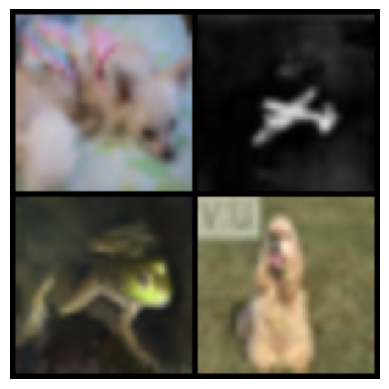

In [12]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

transform = transforms.Compose([
    torchvision.transforms.Resize(64),
    # transforms.RandomCrop(32, padding=4),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, ), (0.5, ))])

train_set = torchvision.datasets.CIFAR10('/hdd1/dataset', transform=transform, train=True, download=True)
dl_train = DataLoader(dataset=train_set, batch_size=4, drop_last=True, shuffle=True)


from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt
import torch

image, _ = next(iter(dl_train))
def gaussian_noise(image: torch.Tensor, sigma_noise: float) -> torch.Tensor:
  return image + sigma_noise * torch.randn_like(image)

degradation_func = lambda im: gaussian_noise(im, 0.2)
low = degradation_func(image)
plt.imshow(make_grid(image, nrow=2, normalize=True).permute(1,2,0))
plt.axis('off')
plt.show()

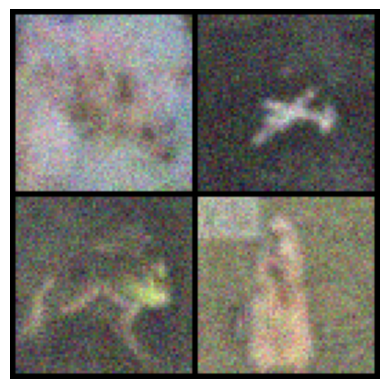

In [14]:
plt.imshow(make_grid(low, nrow=2, normalize=True).permute(1,2,0))
plt.axis('off')
plt.show()

In [2]:
# en = MyResnet(3,32).cuda()
# en = Discriminator(3, 128, 'swish').cuda()
en = EnResnet(3, 64).cuda()
size = 64
print(summary(en, (10, 3, size, size)))

torch.Size([10, 512, 32, 32])
after: torch.Size([10, 512])
Layer (type:depth-idx)                   Output Shape              Param #
EnResnet                                 [10, 1]                   --
├─Sequential: 1-1                        [10, 512, 32, 32]         --
│    └─FirstResBlock: 2-1                [10, 64, 64, 64]          --
│    │    └─Sequential: 3-1              [10, 64, 64, 64]          38,592
│    └─EnResBlock: 2-2                   [10, 64, 64, 64]          --
│    │    └─Sequential: 3-2              [10, 64, 64, 64]          73,728
│    │    └─Sequential: 3-3              [10, 64, 64, 64]          --
│    │    └─Sequential: 3-4              --                        (recursive)
│    └─EnResBlock: 2-3                   [10, 128, 64, 64]         --
│    │    └─Sequential: 3-5              [10, 128, 64, 64]         221,184
│    │    └─Sequential: 3-6              [10, 128, 64, 64]         8,192
│    │    └─Conv2d: 3-7                  [10, 128, 64, 64]         8,19

/hdd1/anaconda/minhyeok/anaconda3/lib/python3.9/site-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/hdd1/anaconda/minhyeok/anaconda3/lib/python3.9/site-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


In [4]:
en=IGEBM(3, 128, 1, activation='silu').cuda()
# unet = UNet(3, 64 // 2, 3).cuda()
size = 64
print(summary(en, (32, 3, size, size)))

Layer (type:depth-idx)                   Output Shape              Param #
IGEBM                                    [32, 1]                   --
├─Sequential: 1-1                        [32, 128, 64, 64]         --
│    └─Conv2d: 2-1                       [32, 128, 64, 64]         3,584
│    └─Swish: 2-2                        [32, 128, 64, 64]         --
│    └─Conv2d: 2-3                       [32, 128, 64, 64]         147,584
├─ModuleList: 1-2                        --                        --
│    └─ResBlock: 2-4                     [32, 128, 64, 64]         --
│    │    └─Conv2d: 3-1                  [32, 128, 64, 64]         147,456
│    │    └─Swish: 3-2                   [32, 128, 64, 64]         --
│    │    └─Conv2d: 3-3                  [32, 128, 64, 64]         147,456
│    │    └─Swish: 3-4                   [32, 128, 64, 64]         --
│    └─ResBlock: 2-5                     [32, 256, 32, 32]         --
│    │    └─Conv2d: 3-5                  [32, 256, 64, 64]         

In [ ]:
en = Res18_Linear

In [15]:
input_channel = 1
def sample_buffer(buffer, batch_size=128, p=0.95, device='cuda'):
    if len(buffer) < 1:
        return (
            torch.randn(batch_size, input_channel, 32, 32, device=device), # gaussian noise
            torch.randint(0, 10, (batch_size,), device=device),
        )

    n_replay = (np.random.rand(batch_size) < p).sum() # batchsize / 95

    replay_sample, replay_id = buffer.get(n_replay)
    random_sample = torch.randn(batch_size - n_replay, input_channel, 32, 32, device=device)
    random_id = torch.randint(0, 10, (batch_size - n_replay,), device=device)

    return (
        torch.cat([replay_sample, random_sample], 0),
        torch.cat([replay_id, random_id], 0),
    )

In [43]:
a = list()

for _ in range(10):
    b=torch.randn(2,2)
    a.append(b)

s= random.choices(a, k=4)
ss = torch.stack(s, 0)
print(type(ss), ss.shape)

<class 'torch.Tensor'> torch.Size([4, 2, 2])


In [16]:
class SampleBuffer:
    def __init__(self, max_samples=10000):
        self.max_samples = max_samples
        self.buffer = []

    def __len__(self):
        return len(self.buffer)

    def push(self, samples, class_ids=None):
        samples = samples.detach().to('cpu')
        # class_ids = class_ids.detach().to('cpu')

        for sample in samples:
            self.buffer.append(sample.detach())

            if len(self.buffer) > self.max_samples:
                self.buffer.pop(0)

    def get(self, n_samples, device='cuda'):
        items = random.choices(self.buffer, k=n_samples)
        # samples, class_ids = zip(*items)
        samples = torch.stack(items, 0)
        # class_ids = torch.tensor(class_ids)
        samples = samples.to(device)
        # class_ids = class_ids.to(device)

        return samples

In [18]:
buffer = SampleBuffer()
len(buffer)
img, id = sample_buffer(buffer, 100)
print(torch.mean(img), torch.min(img), torch.max(img))


tensor(-0.0008, device='cuda:0') tensor(-4.2936, device='cuda:0') tensor(4.3957, device='cuda:0')


In [2]:
en=CondEnergyModel(2, 32, 1).cuda()
import torchsummary
print(torchsummary.summary(en, [(1,32,32),(1,32,32)] ))

/hdd1/anaconda/minhyeok/anaconda3/lib/python3.9/site-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             576
       BatchNorm2d-2           [-1, 32, 16, 16]              64
        Conv_Layer-3           [-1, 32, 16, 16]               0
             Swish-4           [-1, 32, 16, 16]               0
            Conv2d-5             [-1, 64, 8, 8]          18,432
       BatchNorm2d-6             [-1, 64, 8, 8]             128
        Conv_Layer-7             [-1, 64, 8, 8]               0
             Swish-8             [-1, 64, 8, 8]               0
            Conv2d-9            [-1, 128, 4, 4]          73,728
      BatchNorm2d-10            [-1, 128, 4, 4]             256
       Conv_Layer-11            [-1, 128, 4, 4]               0
            Swish-12            [-1, 128, 4, 4]               0
           Conv2d-13            [-1, 256, 2, 2]         294,912
      BatchNorm2d-14            [-1, 25

In [3]:
en=EnergyModel(1, 32, 1).cuda()
import torchsummary
print(torchsummary.summary(en, (1,32,32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]             640
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              SiLU-3           [-1, 64, 16, 16]               0
            Conv2d-4             [-1, 64, 8, 8]          36,928
       BatchNorm2d-5             [-1, 64, 8, 8]             128
              SiLU-6             [-1, 64, 8, 8]               0
 Conv_Double_Layer-7             [-1, 64, 8, 8]               0
             Swish-8             [-1, 64, 8, 8]               0
            Conv2d-9            [-1, 128, 4, 4]          73,856
      BatchNorm2d-10            [-1, 128, 4, 4]             256
             SiLU-11            [-1, 128, 4, 4]               0
           Conv2d-12            [-1, 128, 2, 2]         147,584
      BatchNorm2d-13            [-1, 128, 2, 2]             256
             SiLU-14            [-1, 12

In [3]:

class Swish(nn.Module):
    
    def forward(self, x):
        return x * torch.sigmoid(x)

class CNNModel(nn.Module):

    def __init__(self, hidden_features=32, out_dim=1, **kwargs):
        super().__init__()
        # We increase the hidden dimension over layers. Here pre-calculated for simplicity.
        c_hid1 = hidden_features//2
        c_hid2 = hidden_features
        c_hid3 = hidden_features*2
        
        # Series of convolutions and Swish activation functions
        self.cnn_layers = nn.Sequential(
                nn.Conv2d(1, c_hid1, kernel_size=3, stride=2, padding=1), # [16x16] - Larger padding to get 32x32 image
                Swish(),
                nn.Conv2d(c_hid1, c_hid2, kernel_size=3, stride=2, padding=1), #  [8x8]
                Swish(),
                nn.Conv2d(c_hid2, c_hid3, kernel_size=3, stride=2, padding=1), # [4x4]
                Swish(),
                nn.Conv2d(c_hid3, c_hid3, kernel_size=3, stride=2, padding=1), # [2x2]
                Swish(),
                nn.Flatten(),
                nn.Linear(c_hid3*4, c_hid3),
                Swish(),
                nn.Linear(c_hid3, out_dim)
        )

    def forward(self, x):
        x = self.cnn_layers(x).squeeze(dim=-1)
        return x
    

In [13]:
# x = torch.tensor([[1.0, 2.0],[3.0, 4.0]], requires_grad = True)
x = torch.tensor([[1.0, 2.0],[3.0, 4.0]])
x = x.requires_grad_() # x.requires_grad = True
# tensor([[1., 2.],
#         [3., 4.]], requires_grad=True)

y = x + 2
# tensor([[3., 4.],
#         [5., 6.]], grad_fn=<AddBackward0>)

z = y * y * 3
# tensor([[ 27.,  48.],
#         [ 75., 108.]], grad_fn=<MulBackward0>)

out = z.mean()
# tensor(64.5000, grad_fn=<MeanBackward0>)

out.backward()
print(x.grad)
# xgrad = torch.autograd.grad(out, x)[0]
# print(xgrad)

tensor([[4.5000, 6.0000],
        [7.5000, 9.0000]])


In [4]:
en=CNNModel().cuda()
import torchsummary
print(torchsummary.summary(en, (1,32,32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 16, 16]             160
             Swish-2           [-1, 16, 16, 16]               0
            Conv2d-3             [-1, 32, 8, 8]           4,640
             Swish-4             [-1, 32, 8, 8]               0
            Conv2d-5             [-1, 64, 4, 4]          18,496
             Swish-6             [-1, 64, 4, 4]               0
            Conv2d-7             [-1, 64, 2, 2]          36,928
             Swish-8             [-1, 64, 2, 2]               0
           Flatten-9                  [-1, 256]               0
           Linear-10                   [-1, 64]          16,448
            Swish-11                   [-1, 64]               0
           Linear-12                    [-1, 1]              65
Total params: 76,737
Trainable params: 76,737
Non-trainable params: 0
---------------------------------

In [2]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

transform = torchvision.transforms.Compose([ 
    torchvision.transforms.Resize(32),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Lambda(lambda t: 2 * t - 1) 
])

# the name of the dataset is used as upper case
path_data = '/hdd1/dataset'
dataset_train   = torchvision.datasets.MNIST(path_data, transform=transform, train=True, download=True)
dataset_test    = torchvision.datasets.MNIST(path_data, transform=transform, train=False, download=True)

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=128, shuffle=True,  drop_last=True,  num_workers=4, pin_memory=True)
test_loader  = torch.utils.data.DataLoader(dataset_test,  batch_size=256, shuffle=False, drop_last=True, num_workers=4)

Device: cuda:0


In [4]:
a, _ = next(iter(train_loader))

b = a + 0.2 * torch.randn_like(a)

In [8]:
b = torch.randn_like(a)
print(torch.max(b), torch.min(b), torch.mean(b))

tensor(4.1792) tensor(-4.6518) tensor(0.0047)


In [10]:
class Swish(nn.Module):

    def forward(self, x):
        return x * torch.sigmoid(x)


class CNNModel(nn.Module):

    def __init__(self, hidden_features=32, out_dim=1, **kwargs):
        super().__init__()
        # We increase the hidden dimension over layers. Here pre-calculated for simplicity.
        c_hid1 = hidden_features//2
        c_hid2 = hidden_features
        c_hid3 = hidden_features*2

        # Series of convolutions and Swish activation functions
        self.cnn_layers = nn.Sequential(
                nn.Conv2d(1, c_hid1, kernel_size=3, stride=2, padding=1), # [16x16] - Larger padding to get 32x32 image
                Swish(),
                nn.Conv2d(c_hid1, c_hid2, kernel_size=3, stride=2, padding=1), #  [8x8]
                Swish(),
                nn.Conv2d(c_hid2, c_hid3, kernel_size=3, stride=2, padding=1), # [4x4]
                Swish(),
                nn.Conv2d(c_hid3, c_hid3, kernel_size=3, stride=2, padding=1), # [2x2]
                Swish(),
                nn.Flatten(),
                nn.Linear(c_hid3*4, c_hid3),
                Swish(),
                nn.Linear(c_hid3, out_dim)
        )

    def forward(self, x):
        x = self.cnn_layers(x).squeeze(dim=-1)
        return x
    
class Sampler:

    def __init__(self, model, img_shape, sample_size, max_len=8192):
        """
        Inputs:
            model - Neural network to use for modeling E_theta
            img_shape - Shape of the images to model
            sample_size - Batch size of the samples
            max_len - Maximum number of data points to keep in the buffer
        """
        super().__init__()
        self.model = model
        self.img_shape = img_shape
        self.sample_size = sample_size
        self.max_len = max_len
        self.examples = [(torch.rand((1,)+img_shape)*2-1) for _ in range(self.sample_size)]

    def sample_new_exmps(self, steps=60, step_size=10):
        """
        Function for getting a new batch of "fake" images.
        Inputs:
            steps - Number of iterations in the MCMC algorithm
            step_size - Learning rate nu in the algorithm above
        """
        # Choose 95% of the batch from the buffer, 5% generate from scratch
        n_new = np.random.binomial(self.sample_size, 0.05)
        rand_imgs = torch.rand((n_new,) + self.img_shape) * 2 - 1
        old_imgs = torch.cat(random.choices(self.examples, k=self.sample_size-n_new), dim=0)
        inp_imgs = torch.cat([rand_imgs, old_imgs], dim=0).detach().to(device)

        # Perform MCMC sampling
        inp_imgs = Sampler.generate_samples(self.model, inp_imgs, steps=steps, step_size=step_size)

        # Add new images to the buffer and remove old ones if needed
        self.examples = list(inp_imgs.to(torch.device("cpu")).chunk(self.sample_size, dim=0)) + self.examples
        self.examples = self.examples[:self.max_len]
        return inp_imgs

    @staticmethod
    def generate_samples(model, inp_imgs, steps=60, step_size=10, return_img_per_step=False):
        """
        Function for sampling images for a given model.
        Inputs:
            model - Neural network to use for modeling E_theta
            inp_imgs - Images to start from for sampling. If you want to generate new images, enter noise between -1 and 1.
            steps - Number of iterations in the MCMC algorithm.
            step_size - Learning rate nu in the algorithm above
            return_img_per_step - If True, we return the sample at every iteration of the MCMC
        """
        # Before MCMC: set model parameters to "required_grad=False"
        # because we are only interested in the gradients of the input.
        is_training = model.training
        model.eval()
        for p in model.parameters():
            p.requires_grad = False
        inp_imgs.requires_grad = True

        # Enable gradient calculation if not already the case
        had_gradients_enabled = torch.is_grad_enabled()
        torch.set_grad_enabled(True)

        # We use a buffer tensor in which we generate noise each loop iteration.
        # More efficient than creating a new tensor every iteration.
        noise = torch.randn(inp_imgs.shape, device=inp_imgs.device)

        # List for storing generations at each step (for later analysis)
        imgs_per_step = []

        # Loop over K (steps)
        for _ in range(steps):
            # Part 1: Add noise to the input.
            noise.normal_(0, 0.005)
            inp_imgs.data.add_(noise.data)
            inp_imgs.data.clamp_(min=-1.0, max=1.0)

            # Part 2: calculate gradients for the current input.
            out_imgs = -model(inp_imgs)
            out_imgs.sum().backward()
            inp_imgs.grad.data.clamp_(-0.03, 0.03) # For stabilizing and preventing too high gradients

            # Apply gradients to our current samples
            inp_imgs.data.add_(-step_size * inp_imgs.grad.data)
            inp_imgs.grad.detach_()
            inp_imgs.grad.zero_()
            inp_imgs.data.clamp_(min=-1.0, max=1.0)

            if return_img_per_step:
                imgs_per_step.append(inp_imgs.clone().detach())

        # Reactivate gradients for parameters for training
        for p in model.parameters():
            p.requires_grad = True
        model.train(is_training)

        # Reset gradient calculation to setting before this function
        torch.set_grad_enabled(had_gradients_enabled)

        if return_img_per_step:
            return torch.stack(imgs_per_step, dim=0)
        else:
            return inp_imgs

In [15]:
en = CNNModel().cuda()
sampler = Sampler(en, (1,32, 32), 128)
optimizer = optim.Adam(en.parameters(), lr=0.0001, betas=(0.5, 0.999))
scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.97)


import torchsummary
print(torchsummary.summary(en, (1,32,32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 16, 16]             160
             Swish-2           [-1, 16, 16, 16]               0
            Conv2d-3             [-1, 32, 8, 8]           4,640
             Swish-4             [-1, 32, 8, 8]               0
            Conv2d-5             [-1, 64, 4, 4]          18,496
             Swish-6             [-1, 64, 4, 4]               0
            Conv2d-7             [-1, 64, 2, 2]          36,928
             Swish-8             [-1, 64, 2, 2]               0
           Flatten-9                  [-1, 256]               0
           Linear-10                   [-1, 64]          16,448
            Swish-11                   [-1, 64]               0
           Linear-12                    [-1, 1]              65
Total params: 76,737
Trainable params: 76,737
Non-trainable params: 0
---------------------------------